# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Approach 1: choosing a tape

In [2]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.DoubleExcitation(phi, wires=[12, 11, 0, 9]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.qml.CSWAP(wires=[0, 1, 2]),
    qml.Hadamard(wires=[4]),
    qml.qml.CSWAP(wires=[2, 3, 4]),
    qml.CNOT(wires=[2, 4]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [3]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [4]:
tape.operations

[DoubleExcitation(0.2, wires=[12, 11, 0, 9]),
 X(0),
 RX(0.1, wires=[0]),
 CSWAP(wires=[7, 0, 5]),
 RX(0.2, wires=[1]),
 CNOT(wires=[3, 4]),
 DoubleExcitation(0.2, wires=[1, 2, 3, 4]),
 CSWAP(wires=[0, 1, 2]),
 Hadamard(wires=[4]),
 CSWAP(wires=[2, 3, 4]),
 CNOT(wires=[2, 4]),
 DoubleExcitation(0.2, wires=[0, 1, 3, 4])]

In [5]:
tape.observables

[Z(1), Z(1), Y(2), I(0), Y(4)]

In [6]:
tape.measurements

[expval(Z(1)), expval(Z(1)), var(Y(2)), expval(I(0)), var(Y(4))]

In [7]:
tape.wires

<Wires = [12, 11, 0, 9, 7, 5, 1, 3, 4, 2]>

In [8]:
dev = qml.device("lightning.qubit", wires=tape.wires)

dev.execute(circuits=tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Learning from `LightningQubit` using Python API

In [9]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [10]:
obj = LightningQubit(wires=tape.wires)

In [11]:
obj.tracker

In [12]:
program, config = obj.preprocess()

In [13]:
program[0]

<validate_measurements([], {'name': 'lightning.qubit'})>

In [14]:
obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[12, 11, 0, 9, 7, 5, 1, 3, 4, 2], params=5>,)



(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Testing `LightningTensor` 

In [15]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = None
cutoff = 0.0

In [16]:
from pennylane_lightning.lightning_tensor import LightningTensor

In [17]:
from pennylane_lightning.lightning_tensor import LightningTensor

@qml.qnode(LightningTensor(contract="auto-mps"))
def circuit():
    qml.X(0)
    return qml.expval(qml.Z(0))

circuit()

tensor(-1., requires_grad=True)

In [26]:
from pennylane_lightning.lightning_tensor import LightningTensor



@qml.qnode(LightningTensor(max_bond_dim=100,  wires=qml.wires.Wires(range(2))))
def circuit():
    qml.Z(0)
    return qml.expval(qml.Z(0))

circuit()

tensor(1., requires_grad=True)

In [ ]:
qml.wires.Wires(range(2))

<Wires = [0, 1]>

In [ ]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [ ]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=2)

In [ ]:
# obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

In [ ]:
type(obj._setup_execution_config())

pennylane.devices.execution_config.ExecutionConfig

In [ ]:
program, config = obj.preprocess()

In [ ]:
program[0]

<validate_measurements([], {'name': 'QuimbMPS interface'})>

In [ ]:
config

ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'backend': 'quimb', 'c_dtype': <class 'numpy.complex128'>, 'contract': 'auto-mps', 'cutoff': 0.0, 'method': 'mps', 'max_bond_dim': None}, interface=None, derivative_order=1)

In [ ]:
# program[0]

In [ ]:
# config

In [ ]:
# config.device_options

In [ ]:
obj.execute(circuits=tape)

(0.999950207958725,
 0.999950207958725,
 0.9901818584603544,
 0.9999999999999991,
 0.9999999999999993)

In [ ]:
obj._interface._circuitMPS.gates

[<Gate(label=RAW140247399305008, params=raw, qubits=(0, 1, 2, 3))>,
 <Gate(label=RAW140247407911824, params=raw, qubits=(2,))>,
 <Gate(label=RAW140247403127888, params=raw, qubits=(2,))>,
 <Gate(label=RAW140247399484464, params=raw, qubits=(4, 2, 5))>,
 <Gate(label=RAW140247399485040, params=raw, qubits=(6,))>,
 <Gate(label=RAW140247401802800, params=raw, qubits=(7, 8))>,
 <Gate(label=RAW140247401974352, params=raw, qubits=(6, 9, 7, 8))>,
 <Gate(label=RAW140247399996464, params=raw, qubits=(2, 6, 9))>,
 <Gate(label=RAW140247399676304, params=raw, qubits=(8,))>,
 <Gate(label=RAW140247399465008, params=raw, qubits=(9, 7, 8))>,
 <Gate(label=RAW140247399466448, params=raw, qubits=(9, 8))>,
 <Gate(label=RAW140247399498256, params=raw, qubits=(2, 6, 7, 8))>]

In [ ]:
obj._interface._circuitMPS.psi.tags

oset(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'PSI0', 'I0', 'I1', 'I9', 'I2', 'GATE_1', 'GATE_2', 'I3', 'I4', 'I5', 'I6', 'GATE_4', 'I7', 'I8', 'GATE_8'])

In [ ]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=16)

In [ ]:
obj._interface._circuitMPS.__dict__

{'_psi': MatrixProductState(tensors=10, indices=19, L=10, max_bond=16),
 'N': 10,
 'gate_opts': {'contract': 'auto-mps',
  'info': {'cur_orthog': (2, 2)},
  'propagate_tags': 'register'},
 'gates': [<Gate(label=RAW140247399305008, params=raw, qubits=(0, 1, 2, 3))>,
  <Gate(label=RAW140247407911824, params=raw, qubits=(2,))>,
  <Gate(label=RAW140247403127888, params=raw, qubits=(2,))>,
  <Gate(label=RAW140247399484464, params=raw, qubits=(4, 2, 5))>,
  <Gate(label=RAW140247399485040, params=raw, qubits=(6,))>,
  <Gate(label=RAW140247401802800, params=raw, qubits=(7, 8))>,
  <Gate(label=RAW140247401974352, params=raw, qubits=(6, 9, 7, 8))>,
  <Gate(label=RAW140247399996464, params=raw, qubits=(2, 6, 9))>,
  <Gate(label=RAW140247399676304, params=raw, qubits=(8,))>,
  <Gate(label=RAW140247399465008, params=raw, qubits=(9, 7, 8))>,
  <Gate(label=RAW140247399466448, params=raw, qubits=(9, 8))>,
  <Gate(label=RAW140247399498256, params=raw, qubits=(2, 6, 7, 8))>],
 '_ket_site_ind_id': 'k{}',

In [ ]:
obj._interface._circuitMPS

<Circuit(n=10, num_gates=12, gate_opts={'contract': 'auto-mps', 'info': {'cur_orthog': (2, 2)}, 'propagate_tags': 'register'})>

In [ ]:
obj._interface._circuitMPS.psi.max_bond()

16

In [ ]:
obj._interface._circuitMPS.psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=16)

In [ ]:
obj._interface.draw_state()

AttributeError: 'QuimbMPS' object has no attribute 'draw_state'

In [ ]:
obj._interface._circuitMPS.psi.to_dense()

array([[-9.70721342e-16-3.51640537e-02j],
       [-7.37334931e-17-1.99997141e-16j],
       [-9.54683404e-16-3.51640537e-02j],
       ...,
       [-1.52995922e-17-1.40746439e-17j],
       [-2.72578330e-18+5.65843315e-18j],
       [ 3.03828654e-18-7.13169082e-18j]])

In [ ]:
# obj.compute_derivatives(tape)

In [ ]:
# obj._interface.state_to_array()

In [ ]:
obj._interface._circuitMPS._psi

MatrixProductState(tensors=10, indices=19, L=10, max_bond=32)

# Playing with `quimb`

In [ ]:
wires = Wires(range(7))

init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)

qc = qtn.CircuitMPS(psi0=init_state)

op = qml.CNOT(wires=[0, 1])

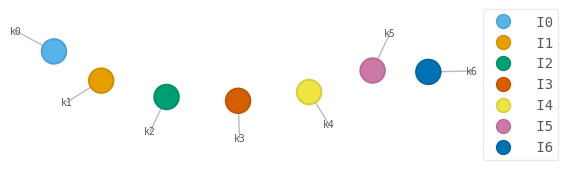

In [ ]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [ ]:
init_state.gate_

functools.partial(<bound method gate_TN_1D of MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)>, inplace=True)

In [ ]:
qc.amplitude("0111111")

0j

In [ ]:
init_state

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [ ]:
qc.ket_site_ind

<function str.format>

In [ ]:
qc.__dict__

{'_psi': MatrixProductState(tensors=7, indices=7, L=7, max_bond=2),
 'N': 7,
 'gate_opts': {'contract': 'auto-mps',
  'info': {},
  'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': 0,
 '_storage': {('psi_simplified',
   'ADCRS',
   1e-12): MatrixProductState(tensors=7, indices=7, L=7, max_bond=2)},
 '_sampled_conditionals': {},
 '_marginal_storage_size': 0}

In [ ]:
qc.gates

[]

In [ ]:
gate = qtn.circuit.parse_to_gate(op.matrix(), tuple(op.wires))

In [ ]:
gate

<Gate(label=RAW135784454390672, params=raw, qubits=((0, 1),))>

In [ ]:
qtn.MPS_computational_state("0" * len(wires), tags=[str(l) for l in wires.labels])

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [ ]:
qtn.MPS_zero_state(bond_dim=6, L=9)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

In [ ]:
qtn.MPS_rand_state(L=9, bond_dim=6)

MatrixProductState(tensors=9, indices=17, L=9, max_bond=6)

# Question for the guy

In [ ]:
import pennylane as qml
import quimb.tensor as qtn
import numpy as np

# case 1: single qubit gate (works fine)
op1 = qml.PauliX(wires=[0])
qtn.Circuit(N=1).apply_gate(
    op1.matrix().astype(np.complex128), *op1.wires, parametrize=None
)

# case 2: two qubit gate (works fine)
op2 = qml.CNOT(wires=[0, 1])
qtn.Circuit(N=2).apply_gate(
    op2.matrix().astype(np.complex128), *op2.wires, parametrize=None
)

# case 3: three qubit gate (fails)
op3 = qml.Toffoli(wires=[0, 1, 2])
# qtn.CircuitMPS(N=3).apply_gate(op3.matrix(), *op3.wires, parametrize=None)

# case 4: four qubit gate (fails)
op4 = qml.DoubleExcitation(0.1, wires=[0, 1, 2, 3])
# qtn.Circuit(N=4).apply_gate(op4.matrix().astype(np.complex128), *op4.wires, parametrize=None)

In [ ]:
ops = [
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.CZ(wires=[4, 5]),
    qml.Hadamard(wires=[4]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.CSWAP(wires=[2, 3, 4]),
    qml.QFT(wires=[0, 1, 2]),
    qml.CNOT(wires=[2, 4]),
    qml.Toffoli(wires=[0, 1, 2]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [ ]:
obj = LightningQubit(wires=tape.wires)

obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 7, 5, 1, 3, 4, 2], params=4>,)



(0.10157883318982944, 0.10157883318982944, 1.0, 0.9881722793134764, 1.0, 1.0)

In [ ]:
qml.Rot(0.2, -0.4, 0.3, wires=[2]).matrix()

array([[ 0.94959868-0.24247235j,  0.19842105-0.00992933j],
       [-0.19842105-0.00992933j,  0.94959868+0.24247235j]])

In [ ]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.1015788331898218,
 0.1015788331898218,
 0.999999999999981,
 0.9881722793134597,
 0.999999999999981,
 0.999999999999981)

In [ ]:
import pennylane as qml

# Define the operations
ops = [
    qml.Hadamard(wires=[0]),
    qml.CRX(0.5, wires=[1, 2]),
    qml.CNOT(wires=[0, 1]),
    qml.CRX(0.3, wires=[2, 3]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.CZ(wires=[4, 5]),
    qml.Hadamard(wires=[4]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.CSWAP(wires=[2, 3, 4]),
    qml.QFT(wires=[0, 1, 2]),
    qml.CNOT(wires=[2, 4]),
    qml.Toffoli(wires=[0, 1, 2]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
    qml.CSWAP(wires=[1, 2, 3]),
    qml.RX(-0.8, wires=[0]),
    qml.CZ(wires=[0, 2]),
    qml.RY(0.4, wires=[1]),
    qml.CNOT(wires=[1, 3]),
    qml.CCZ(wires=[0, 1, 2]),
    qml.Hadamard(wires=[3])
]

# Define the measurement
meas = [
    qml.expval(qml.PauliX(wires=[0])),
    qml.var(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.expval(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

In [ ]:
obj = LightningQubit(
    wires=tape.wires,
    c_dtype=c_dtype,
)


obj.execute(tape)

Frisus log: execute called with:
execution_config=ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={}, interface=None, derivative_order=1)
circuits=(<QuantumScript: wires=[0, 1, 2, 3, 7, 5, 4], params=8>,)



(0.2697347514992784,
 0.9022098454128101,
 0.4999999999999998,
 0.7500118092151864)

In [ ]:
obj = LightningTensor(
    wires=tape.wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.2697347514992825, 0.9022098454128122, 0.500000000000004, 0.7500118092151926)

In [ ]:
import pennylane as qml

# Define the operations
ops = [
    qml.Rot(-0.3, 0.7, -0.4, wires=[0]),
    qml.RY(0.8, wires=[1]),
    qml.CNOT(wires=[1, 2]),
    qml.CRX(0.2, wires=[0, 2]),
    qml.PauliY(wires=[1]),
    qml.CZ(wires=[0, 3]),
    qml.Hadamard(wires=[2]),
    qml.CSWAP(wires=[1, 2, 3]),
    qml.Rot(0.1, 0.5, 0.3, wires=[0]),
    qml.CRX(-0.6, wires=[2, 3]),
    qml.RX(0.4, wires=[1]),
    qml.CNOT(wires=[0, 1]),
    qml.Toffoli(wires=[0, 1, 3])
]

# Define the measurement
meas = [
    qml.var(qml.PauliX(wires=[0])),
    qml.expval(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.var(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)


In [ ]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.893103946092743,
 0.09691449955719036,
 0.8483533546735812,
 0.2836662418876177)

In [ ]:
import pennylane as qml

# Define the operations
ops = [
    qml.Rot(0.1, -0.5, 0.6, wires=[0]),
    qml.RX(-0.2, wires=[1]),
    qml.CSWAP(wires=[0, 1, 2]),
    qml.RY(0.3, wires=[2]),
    qml.CNOT(wires=[1, 3]),
    qml.PauliX(wires=[2]),
    qml.CRX(0.4, wires=[0, 3]),
    qml.Hadamard(wires=[1]),
    qml.CCZ(wires=[0, 1, 3]),
    qml.CRX(0.7, wires=[2, 3]),
    qml.CZ(wires=[0, 1]),
    qml.Toffoli(wires=[0, 2, 3])
]

# Define the measurement
meas = [
    qml.expval(qml.PauliZ(wires=[0])),
    qml.var(qml.PauliY(wires=[1])),
    qml.expval(qml.PauliZ(wires=[2])),
    qml.var(qml.PauliX(wires=[3]))
]

# Create the QuantumScript tape
tape = qml.tape.QuantumScript(ops=ops, measurements=meas)


In [ ]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)


obj.execute(tape)

(0.877582561890374,
 1.0000000000000022,
 -0.9541708838044183,
 1.0000000000000022)

In [ ]:
def from_op_to_tensor(op) -> qtn.Tensor:
    """Returns the Quimb tensor corresponding to a PennyLane operator."""
    wires = tuple(op.wires)
    bra_inds = []
    for _, i in enumerate(wires):
        bra_inds.append(f"b{i}")
    bra_inds = tuple(bra_inds)
    ket_inds = []
    for _, i in enumerate(wires):
        ket_inds.append(f"k{i}")
    ket_inds = tuple(ket_inds)
    array = op.matrix().astype(np.complex128)
    return qtn.Tensor(array.reshape([2] * int(np.log2(array.size))), inds=bra_inds + ket_inds)


In [ ]:
op = qml.DoubleExcitation(0.1, wires=[0, 1, 2, 3])

from_op_to_tensor(op)

Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2), inds=('b0', 'b1', 'b2', 'b3', 'k0', 'k1', 'k2', 'k3'), tags=oset([]))